### Import libraries

In [12]:
# %load Kaggle - Zomato_combined.py
#!/usr/bin/env python

import os
import warnings
warnings.filterwarnings('ignore')
os.chdir('/Users/gosc/Desktop/Kaggle/Zomato - Bangalore') 


### data analysis
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams

### text processing
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from collections import Counter
import operator

#### geolocation
import geopy
from geopy import geocoders
from geopy.geocoders import Nominatim

# lib for pandas profiling
import pandas_profiling
pd.options.display.max_columns = 30


### Read Data

In [13]:
data=pd.read_csv('zomato.csv',encoding='latin-1')
print('Data size is:')
print(len(data))
#data.head(5)

Data size is:
51717


### Data understanding

#### Duplications

In [14]:
DataFull=data.copy()  # dataset copied with purpose of 'listed analysis'
DuplicatedRows = data[data.duplicated(subset=['name','address'])]
print("Dups count:", len(DuplicatedRows))
#DuplicatedRows.head(20)

Dups count: 39218


In [15]:
data= data.drop_duplicates(subset=['name','address'],keep='first') #assumption of distinct identifier

In [16]:
### Overview - example
#print("Initial data set example:")
#DataFull[DataFull['name']=='Onesta']
#DuplicatedRows[DuplicatedRows['name']=='Onesta']
#len(data) -12.5 K

In [17]:
#print("Filtered dataset exampe:")
#data[data['name']=='Onesta']

In [18]:
len(data)

12499

#### Data Types

In [19]:
for col in data.columns:
    dtype = str(data[col].dtype)
    print(col, dtype)

url object
address object
name object
online_order object
book_table object
rate object
votes int64
phone object
location object
rest_type object
dish_liked object
cuisines object
approx_cost(for two people) object
reviews_list object
menu_item object
listed_in(type) object
listed_in(city) object


##### Number of Nulls


In [20]:
print('Number of nulls:')
round((data.isnull() | data.isna()).sum()/len(data),3)
#data[(data.menu_item.notnull()) & ~(data.menu_item.isna())]

Number of nulls:


url                            0.000
address                        0.000
name                           0.000
online_order                   0.000
book_table                     0.000
rate                           0.192
votes                          0.000
phone                          0.021
location                       0.001
rest_type                      0.005
dish_liked                     0.631
cuisines                       0.002
approx_cost(for two people)    0.005
reviews_list                   0.000
menu_item                      0.000
listed_in(type)                0.000
listed_in(city)                0.000
dtype: float64

##### Number of Unique Values

In [21]:
print('Number of unique values in the data')
print(data.nunique()) # maybe we still have some dups around 1 K but I am leaving like this
# Generate data report using pandas profile analysis
#profile = data.profile_report(title='Zomato profile analysis report')
#profile.to_file(output_file="zomato data analysis.html")

Number of unique values in the data
url                            12499
address                        11495
name                            8792
online_order                       2
book_table                         2
rate                              61
votes                           1242
phone                          10898
location                          93
rest_type                         93
dish_liked                      4277
cuisines                        2609
approx_cost(for two people)       70
reviews_list                    9966
menu_item                       2279
listed_in(type)                    7
listed_in(city)                   30
dtype: int64


### Data Preprocessing

##### Dropping some columns

In [22]:
data.drop(['url','phone','address'],inplace=True,axis=1)
DataFull.drop(['url','phone','address'],inplace=True,axis=1)

In [23]:
data.columns.values

array(['name', 'online_order', 'book_table', 'rate', 'votes', 'location',
       'rest_type', 'dish_liked', 'cuisines',
       'approx_cost(for two people)', 'reviews_list', 'menu_item',
       'listed_in(type)', 'listed_in(city)'], dtype=object)

In [24]:
DataFull.columns.values

array(['name', 'online_order', 'book_table', 'rate', 'votes', 'location',
       'rest_type', 'dish_liked', 'cuisines',
       'approx_cost(for two people)', 'reviews_list', 'menu_item',
       'listed_in(type)', 'listed_in(city)'], dtype=object)

##### Renaming columns

In [25]:
data.rename(columns=
        {'name':'rest_name','approx_cost(for two people)': 'meal_cost', 'listed_in(city)':
         'Neighbourhood','listed_in(type)': 'restaurant_type','rest_type':'restaurant_category'}, inplace=True)
data.columns.values

array(['rest_name', 'online_order', 'book_table', 'rate', 'votes',
       'location', 'restaurant_category', 'dish_liked', 'cuisines',
       'meal_cost', 'reviews_list', 'menu_item', 'restaurant_type',
       'Neighbourhood'], dtype=object)

In [26]:
DataFull.rename(columns=
        {'name':'rest_name','approx_cost(for two people)': 'meal_cost', 'listed_in(city)':
         'listed_city','listed_in(type)': 'restaurant_type','rest_type':'restaurant_category'}, inplace=True)
DataFull.columns.values

array(['rest_name', 'online_order', 'book_table', 'rate', 'votes',
       'location', 'restaurant_category', 'dish_liked', 'cuisines',
       'meal_cost', 'reviews_list', 'menu_item', 'restaurant_type',
       'listed_city'], dtype=object)

In [234]:
#np.mean(data.rate)

##### Preprocessing 

In [27]:
def preprocessing(data=data):
    data.rate = data.rate.astype(str).apply(lambda x: x.replace('/5',''))
    data.rate = data.rate.astype(str).apply(lambda x: x.replace(',/n',''))
    data.loc[(data.rate =='NEW') | (data.rate =='-'), 'rate'] = np.nan
    data.rate = data.rate.apply(lambda x: float(x))
    data.rate = data.rate.replace(np.nan, np.mean(data.rate))
    data['meal_cost'] = data['meal_cost'].str.replace(',', '').astype(float)
    data['votes'] = data['votes'].astype(float)
    data['rest_name'] = data['rest_name'].str.strip()
    data['rest_name'] = data['rest_name'].replace(['[^A-Za-z0-9_.,!"\s]+'], [''], regex=True)

In [28]:
preprocessing(data=data)

In [29]:
preprocessing(data=DataFull)

### Variable enginering

##### Dish liked

In [245]:
# #May be number of dishesh liked 
# There is a mistake as nan has been counted as one
# #All the dishes liked are distinct and unique.
data['num_dishes_liked'] = data['dish_liked'].astype('str').apply(lambda x: len(x.split(',') if x!=np.nan else 0))

##### Dummy cuisine variable

In [246]:
z =[]
for i in data['cuisines'].astype('str').apply(lambda x: x.split(',')):
    for j in i:
        z.append(j.strip())
cusine_dict = Counter(z)  # create a dictionary based on values in list


cusine_dict=sorted(cusine_dict.items(), key=lambda x: x[1], reverse=True) # sort dictonary based on values of dictionary

# # Create boolean variables with cuisine type

#List for all the categories created
cuisine_type=['north indian','chinese','south indian','continental','cafe','fast food','beverages','italian','american','desserts']


data['cuisines']=data['cuisines'].astype('str').apply(lambda x: x.lower())# #Convert all the cuisine types into lower charatcers
data['cuisines']=data['cuisines'].astype('str').apply(lambda x: x.strip())# #Remove all the leading and trailing spaces from strings


# #replace all the categories which can be converted into meaningful categories - This categories have been created based on knowledge of food

data['cuisines_replaced']=data['cuisines'].replace({'pizza':'italian','bakery':'cafe','coffee':'cafe','ice cream':'desserts',
                                                   'street food':'fast food', 'andhra':'south indian', 'kerala':'south indian',
                                                   'biryani':'south indian', 'mughlai':'north indian', 'bihari':'north indian',
                                                   'rajasthani':'north indian', 'bengali':'north indian', 'bengali':'north indian',
                                                   'rajasthani':'north indian', 'salad':'continental', 'juices':'beverages',
                                                   'mithai':'desserts', 'mangalorean':'south indian', 'burger':'american','sandwich':'american',
                                                   'eastasian':'chinese','east asian':'thai','east asian':'asian', 'east asian':'pan asian'}, regex= True)



In [247]:
data

,rest_name,online_order,book_table,rate,votes,location,restaurant_category,dish_liked,cuisines,meal_cost,reviews_list,menu_item,restaurant_type,Neighbourhood,num_dishes_liked,cuisines_replaced
0,Jalsa,Yes,Yes,4.100000,775.0,Banashankari,Casual Dining,"Pasta, Lunch Buffet, Masala Papad, Paneer Laja...","north indian, mughlai, chinese",800.0,"[('Rated 4.0', 'RATED\n A beautiful place to ...",[],Buffet,Banashankari,7,"north indian, north indian, chinese"
1,Spice Elephant,Yes,No,4.100000,787.0,Banashankari,Casual Dining,"Momos, Lunch Buffet, Chocolate Nirvana, Thai G...","chinese, north indian, thai",800.0,"[('Rated 4.0', 'RATED\n Had been here for din...",[],Buffet,Banashankari,7,"chinese, north indian, thai"
2,San Churro Cafe,Yes,No,3.800000,918.0,Banashankari,"Cafe, Casual Dining","Churros, Cannelloni, Minestrone Soup, Hot Choc...","cafe, mexican, italian",800.0,"[('Rated 3.0', ""RATED\n Ambience is not that ...",[],Buffet,Banashankari,7,"cafe, mexican, italian"
3,Addhuri Udupi Bhojana,No,No,3.700000,88.0,Banashankari,Quick Bites,Masala Dosa,"south indian, north indian",300.0,"[('Rated 4.0', ""RATED\n Great food and proper...",[],Buffet,Banashankari,1,"south indian, north indian"
4,Grand Village,No,No,3.800000,166.0,Basavanagudi,Casual Dining,"Panipuri, Gol Gappe","north indian, rajasthani",600.0,"[('Rated 4.0', 'RATED\n Very good restaurant ...",[],Buffet,Banashankari,2,"north indian, north indian"
5,Timepass Dinner,Yes,No,3.800000,286.0,Basavanagudi,Casual Dining,"Onion Rings, Pasta, Kadhai Paneer, Salads, Sal...",north indian,600.0,"[('Rated 3.0', 'RATED\n Food 3/5\nAmbience 3/...",[],Buffet,Banashankari,7,north indian
6,Rosewood International Hotel Bar Restaurant,No,No,3.600000,8.0,Mysore Road,Casual Dining,NaN,"north indian, south indian, andhra, chinese",800.0,"[('Rated 5.0', 'RATED\n Awesome food ??Great ...",[],Buffet,Banashankari,1,"north indian, south indian, south indian, chinese"
7,Onesta,Yes,Yes,4.600000,2556.0,Banashankari,"Casual Dining, Cafe","Farmhouse Pizza, Chocolate Banana, Virgin Moji...","pizza, cafe, italian",600.0,"[('Rated 5.0', 'RATED\n I personally really l...",[],Cafes,Banashankari,7,"italian, cafe, italian"
8,Penthouse Cafe,Yes,No,4.000000,324.0,Banashankari,Cafe,"Pizza, Mocktails, Coffee, Nachos, Salad, Pasta...","cafe, italian, continental",700.0,"[('Rated 3.0', ""RATED\n I had been to this pl...",[],Cafes,Banashankari,7,"cafe, italian, continental"
9,Smacznego,Yes,No,4.200000,504.0,Banashankari,Cafe,"Waffles, Pasta, Coleslaw Sandwich, Choco Waffl...","cafe, mexican, italian, momos, beverages",550.0,"[('Rated 4.0', ""RATED\n Easy to locate\nVFM 3...",[],Cafes,Banashankari,7,"cafe, mexican, italian, momos, beverages"


In [248]:
###Create dummy variables based on each string in variables cuisines.

temp=data.cuisines_replaced.str.get_dummies(sep=', ')


# #Create list of cuisines which are not part of cuisines category created.
# #We consider category which is not part of cuisine_type is rest_cuisines.

not_in_list = [col for col in temp.columns if col not in cuisine_type]
temp['rest_cusines']= temp[not_in_list].max(1)
cuisine_type.append('rest_cusines') # append list with rest_cuisine category
##reindex the dataframe temp with only categories we want from cuisine_type

temp= temp.reindex(cuisine_type, axis=1, fill_value=0)

# #concat the dataframes to get a single dataframe

data= pd.concat((data, temp), axis=1)

In [203]:
data

,rest_name,online_order,book_table,rate,votes,location,restaurant_category,dish_liked,cuisines,meal_cost,reviews_list,menu_item,restaurant_type,Neighbourhood,num_dishes_liked,cuisines_replaced,north indian,chinese,south indian,continental,cafe,fast food,beverages,italian,american,desserts,rest_cusines
0,Jalsa,Yes,Yes,4.1,775.0,Banashankari,Casual Dining,"Pasta, Lunch Buffet, Masala Papad, Paneer Laja...","north indian, mughlai, chinese",800.0,"[('Rated 4.0', 'RATED\n A beautiful place to ...",[],Buffet,Banashankari,7,"north indian, north indian, chinese",1,1,0,0,0,0,0,0,0,0,0
1,Spice Elephant,Yes,No,4.1,787.0,Banashankari,Casual Dining,"Momos, Lunch Buffet, Chocolate Nirvana, Thai G...","chinese, north indian, thai",800.0,"[('Rated 4.0', 'RATED\n Had been here for din...",[],Buffet,Banashankari,7,"chinese, north indian, thai",1,1,0,0,0,0,0,0,0,0,1
2,San Churro Cafe,Yes,No,3.8,918.0,Banashankari,"Cafe, Casual Dining","Churros, Cannelloni, Minestrone Soup, Hot Choc...","cafe, mexican, italian",800.0,"[('Rated 3.0', ""RATED\n Ambience is not that ...",[],Buffet,Banashankari,7,"cafe, mexican, italian",0,0,0,0,1,0,0,1,0,0,1
3,Addhuri Udupi Bhojana,No,No,3.7,88.0,Banashankari,Quick Bites,Masala Dosa,"south indian, north indian",300.0,"[('Rated 4.0', ""RATED\n Great food and proper...",[],Buffet,Banashankari,1,"south indian, north indian",1,0,1,0,0,0,0,0,0,0,0
4,Grand Village,No,No,3.8,166.0,Basavanagudi,Casual Dining,"Panipuri, Gol Gappe","north indian, rajasthani",600.0,"[('Rated 4.0', 'RATED\n Very good restaurant ...",[],Buffet,Banashankari,2,"north indian, north indian",1,0,0,0,0,0,0,0,0,0,0
5,Timepass Dinner,Yes,No,3.8,286.0,Basavanagudi,Casual Dining,"Onion Rings, Pasta, Kadhai Paneer, Salads, Sal...",north indian,600.0,"[('Rated 3.0', 'RATED\n Food 3/5\nAmbience 3/...",[],Buffet,Banashankari,7,north indian,1,0,0,0,0,0,0,0,0,0,0
6,Rosewood International Hotel Bar Restaurant,No,No,3.6,8.0,Mysore Road,Casual Dining,NaN,"north indian, south indian, andhra, chinese",800.0,"[('Rated 5.0', 'RATED\n Awesome food ??Great ...",[],Buffet,Banashankari,1,"north indian, south indian, south indian, chinese",1,1,1,0,0,0,0,0,0,0,0
7,Onesta,Yes,Yes,4.6,2556.0,Banashankari,"Casual Dining, Cafe","Farmhouse Pizza, Chocolate Banana, Virgin Moji...","pizza, cafe, italian",600.0,"[('Rated 5.0', 'RATED\n I personally really l...",[],Cafes,Banashankari,7,"italian, cafe, italian",0,0,0,0,1,0,0,1,0,0,0
8,Penthouse Cafe,Yes,No,4.0,324.0,Banashankari,Cafe,"Pizza, Mocktails, Coffee, Nachos, Salad, Pasta...","cafe, italian, continental",700.0,"[('Rated 3.0', ""RATED\n I had been to this pl...",[],Cafes,Banashankari,7,"cafe, italian, continental",0,0,0,1,1,0,0,1,0,0,0
9,Smacznego,Yes,No,4.2,504.0,Banashankari,Cafe,"Waffles, Pasta, Coleslaw Sandwich, Choco Waffl...","cafe, mexican, italian, momos, beverages",550.0,"[('Rated 4.0', ""RATED\n Easy to locate\nVFM 3...",[],Cafes,Banashankari,7,"cafe, mexican, italian, momos, beverages",0,0,0,0,1,0,1,1,0,0,1


##### Variable votes based on intervals

In [204]:
#data['votes_new']= pd.qcut(data['votes'],4, labels = False)
data['votes_new']= pd.qcut(data.votes.rank(method='first'), 4)
data['votes_new'].value_counts()
#data.drop(['votes'],axis=1, inplace = True)

(9374.5, 12499.0]    3125
(3125.5, 6250.0]     3125
(0.999, 3125.5]      3125
(6250.0, 9374.5]     3124
Name: votes_new, dtype: int64

### EDA & Plotting

#### Color Map

In [43]:
color_map=['#FF9AA2','#FFDAC1', '#F1F0CF','#d6f8e9','#B5EAD7','#D3EEFF','#C1BBDD','#DCFFFB','#ADE6D0']
color_map2 = ['Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds','YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu',
            'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn']

#### Plot definitions

In [44]:
def countplot(data, feature,limit=30, size=(16,4)):
    plt.figure(figsize=size)
    sns.countplot(data[feature], 
    palette='GnBu_d',order = data[feature].value_counts().head(limit).index)
    plt.title("Number of Observation per "+feature)
    plt.xticks(rotation=90)

In [45]:
def VotesCount(feature, limit=50, data=data, size=(12, 6)):
    group = data['votes'].groupby(data[feature])
    sum_vote = group.sum().sort_values(ascending=False)
    sum_vote.head(limit).plot(kind='bar', figsize=size, color='indianred', alpha=0.8);

In [46]:
def StackBarVotes(level_1, level_2, Agg, data=data, color=color_map, limit=25):
    group=data.groupby([level_1,level_2])
    g= group.sum()[Agg]
    g = g.unstack()
    g['sumval']=g.sum(axis = 1, skipna = True)
    g=g.sort_values('sumval', ascending=False).head(limit)
    g = g.drop(['sumval'], axis=1)
    g.plot(kind='bar', figsize=(10, 4), color=color, stacked=True)

In [47]:
def StackBarVotes2(level_1, level_2, Agg, perc=5, colors="tab20c"):
    group=data.groupby([level_1,level_2]).agg({Agg: ['sum']})
    g=group.reset_index()
    gperc = group.groupby(level=0).apply(lambda x:100 * x / float(x.sum()))
    gpercf= gperc[gperc > perc].reset_index().dropna()
    gg = g.iloc[gpercf.index]
    k=gg.set_index([level_1, level_2]).sort_index(level=[level_1, level_2])
    ki=k.unstack()
    ki['sumval']=ki.sum(axis = 1, skipna = True)
    ki=ki.sort_values('sumval', ascending=False)
    ki = ki.drop(['sumval'], axis=1)
    ki.plot(kind='bar', figsize=(16, 10), cmap=colors, stacked=True)


In [48]:
def scatterplot(x, y, hue, data, h=13.7, w=10.27):
    sns.set(rc={'figure.figsize':((h,w))})
    sns.scatterplot(x=x, y=y, hue=hue,
                palette='Set3', data=data)

#### Number of records per feature

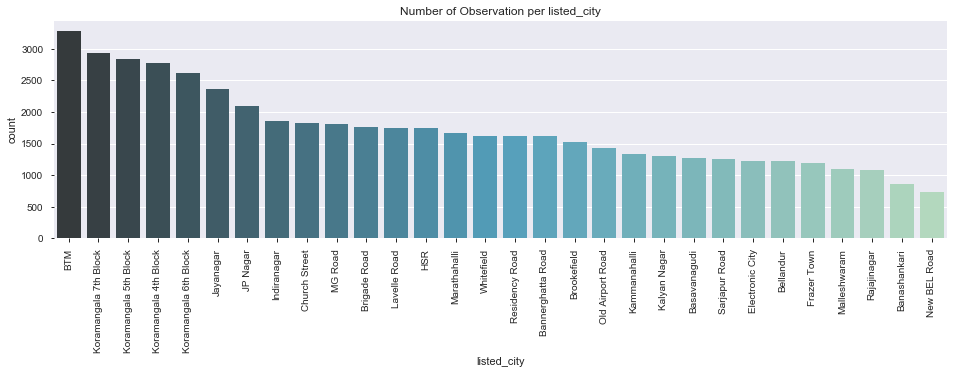

In [49]:
### Here more records than we have since some restaurants are assigned to more than one city
countplot(DataFull, 'listed_city')

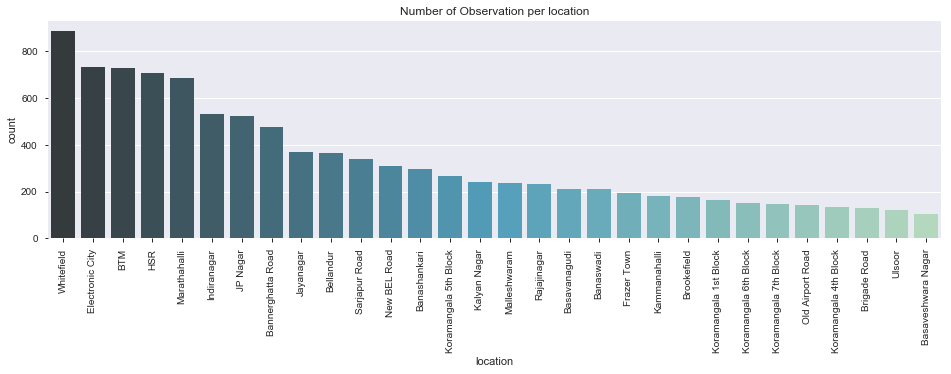

In [50]:
countplot(data, 'location')

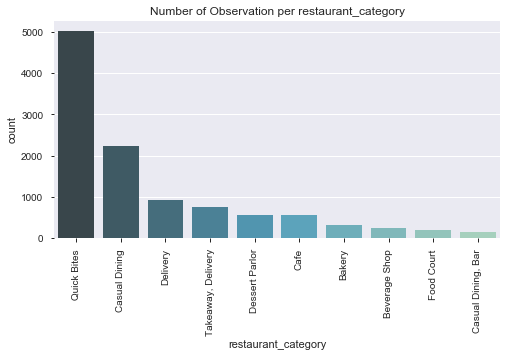

In [51]:
# 10 types of restaurants with the highest number of reviews
countplot(data, 'restaurant_category', 10, (8,4))

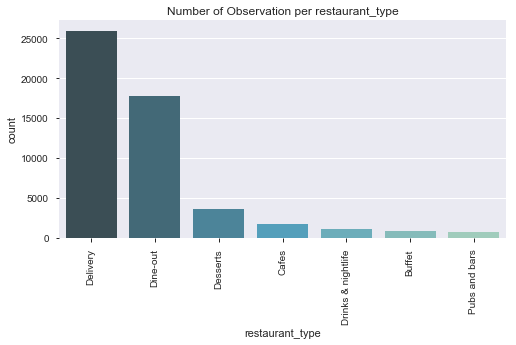

In [52]:
# Restaurants by Category 
countplot(DataFull, 'restaurant_type',10,(8,4)) ##same situaion - multiple types per rest possible

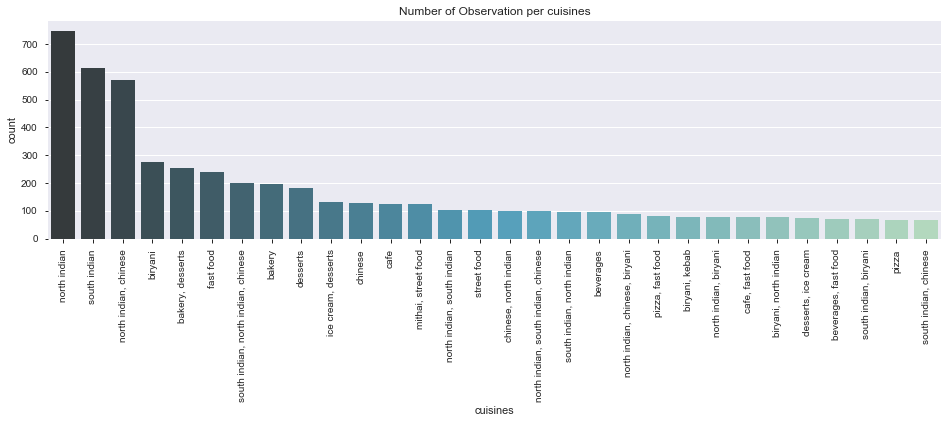

In [53]:
countplot(data, 'cuisines')

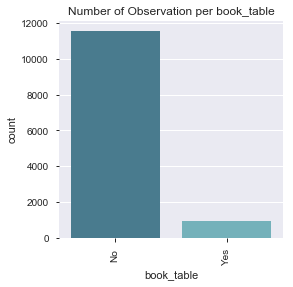

In [54]:
countplot(data, 'book_table',10,(4,4))

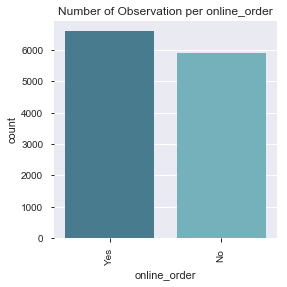

In [55]:
countplot(data, 'online_order',10,(4,4))

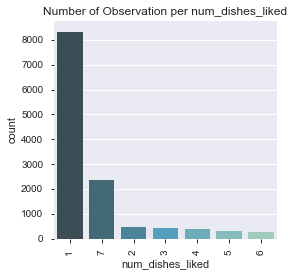

In [56]:
countplot(data, 'num_dishes_liked',10,(4,4))

#### New cusine plot ( dummy)

In [205]:
cuisine_new={}
list_cuisines=['north indian', 'chinese',
       'south indian', 'continental', 'cafe', 'fast food', 'beverages',
       'italian', 'american', 'desserts', 'rest_cusines']
for i in list_cuisines:
    #print(i, sum(data[i]))
    cuisine_new[i] = sum(data[i])

In [206]:
cuisine_new = sorted(cuisine_new.items(), key=operator.itemgetter(1), reverse=True)
cuisine_new = dict(cuisine_new)

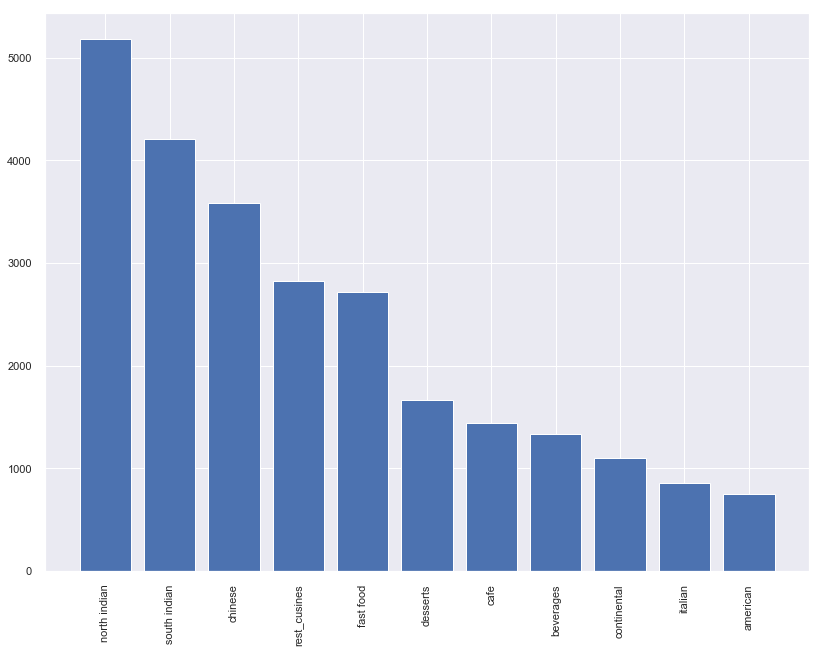

In [207]:
#plot
plt.bar(range(len(cuisine_new)), cuisine_new.values(), align='center')
plt.xticks(range(len(cuisine_new)), list(cuisine_new.keys()), rotation=90)

plt.show()

##### Number of Votes per feature

##### location

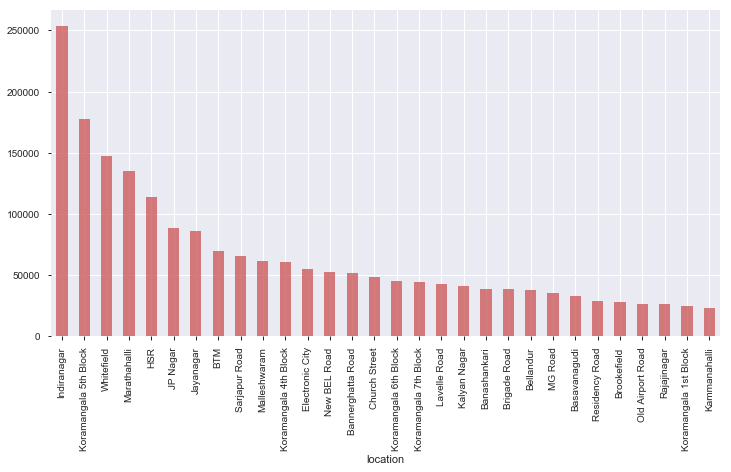

In [60]:
VotesCount('location', 30)

#### City Listed

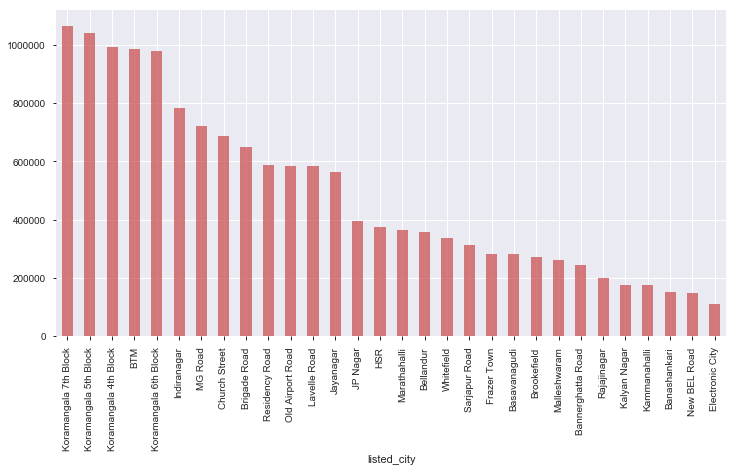

In [61]:
VotesCount('listed_city',data=DataFull)

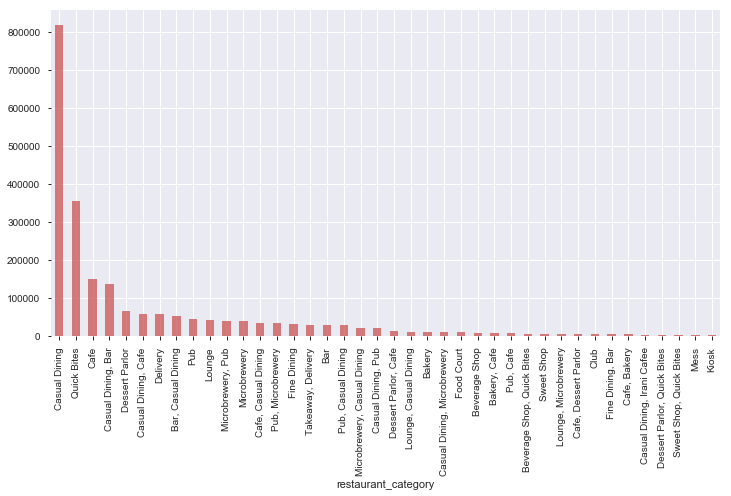

In [62]:
VotesCount('restaurant_category',40)

##### Restaurant Type

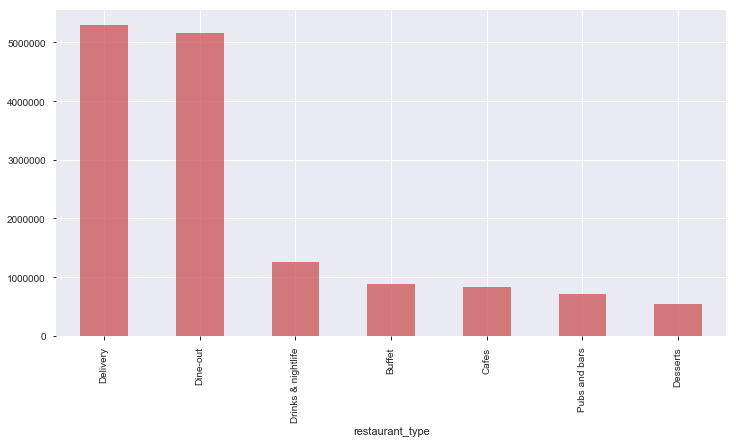

In [63]:
VotesCount('restaurant_type', 20, data=DataFull)

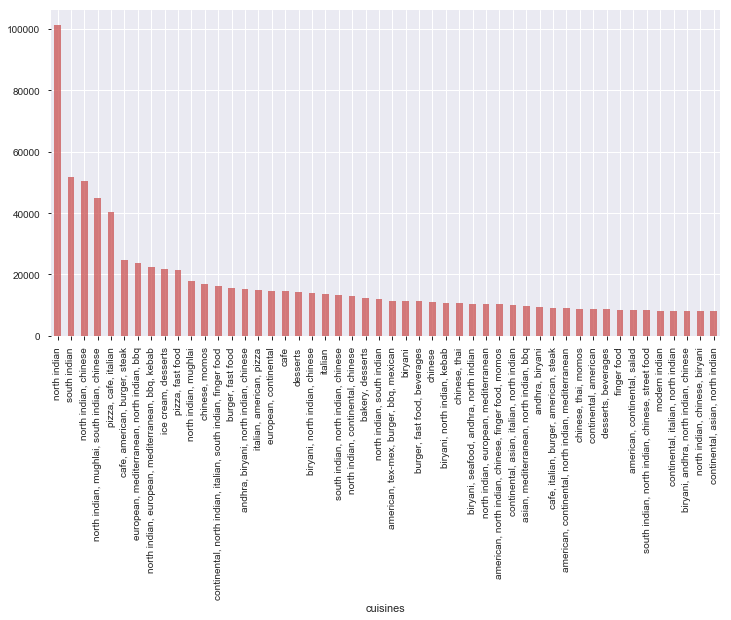

In [64]:
VotesCount('cuisines', data=data)

### New cusine votes and rates

In [208]:
cuisine_votes= {i: 0 for i in list_cuisines} 
cuisine_rate={i: 0 for i in list_cuisines}
CuisineRateVote=[]

for i in list_cuisines:
    n=0
    for index, row in data.iterrows():
        if row[i]==1:
            cuisine_votes[i] += row['votes'] #Number of votes
            cuisine_rate[i] += row['rate']
                #i changed previous code to change rate 'new' and '-' to 0 
                #-> but this actually increases denominator, and mean for such record are across whole ds
                #so it could over/underestimate -> so here exclude
                n +=1
    cuisine_rate[i]=round(cuisine_rate[i]/n,2) #avg rate
    CuisineRateVote.append([i, n, cuisine_rate[i], cuisine_votes[i]])
CuisineRateVoteDF=pd.DataFrame(CuisineRateVote)

In [209]:
CuisineRateVoteDF.columns = ['Cuisine', 'n','rate','votes']

In [210]:
CuisineRateVoteDF

,Cuisine,n,rate,votes
0,north indian,3949,NaN,1126328.0
1,chinese,2834,NaN,661995.0
2,south indian,3001,NaN,555792.0
3,continental,940,3.89,596985.0
4,cafe,1132,3.72,315295.0
5,fast food,2079,3.57,278915.0
6,beverages,980,3.71,183160.0
7,italian,762,3.82,439055.0
8,american,647,3.79,362098.0
9,desserts,1277,3.75,206442.0


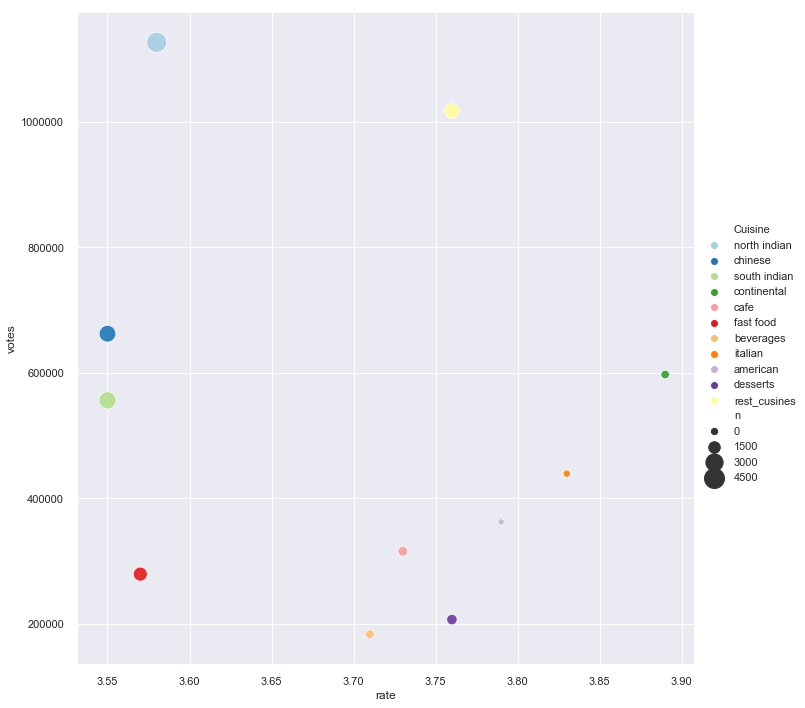

In [160]:
### Visualization
sns.relplot(x="rate", y="votes", hue="Cuisine", size="n",
            sizes=(40, 400), alpha=.9, palette="Paired",
            height=10, data=CuisineRateVoteDF)

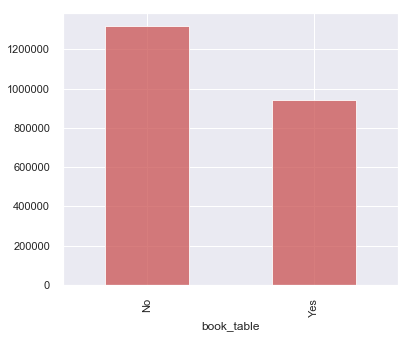

In [129]:
VotesCount('book_table', 2, data, (6, 5))

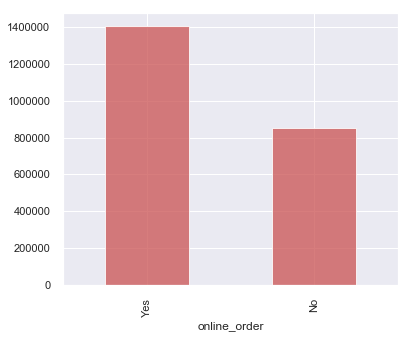

In [130]:
VotesCount('online_order', 2, data, (6, 5))

In [133]:
DataFull

,rest_name,online_order,book_table,rate,votes,location,restaurant_category,dish_liked,cuisines,meal_cost,reviews_list,menu_item,restaurant_type,listed_city
0,Jalsa,Yes,Yes,4.1,775.0,Banashankari,Casual Dining,"Pasta, Lunch Buffet, Masala Papad, Paneer Laja...","North Indian, Mughlai, Chinese",800.0,"[('Rated 4.0', 'RATED\n A beautiful place to ...",[],Buffet,Banashankari
1,Spice Elephant,Yes,No,4.1,787.0,Banashankari,Casual Dining,"Momos, Lunch Buffet, Chocolate Nirvana, Thai G...","Chinese, North Indian, Thai",800.0,"[('Rated 4.0', 'RATED\n Had been here for din...",[],Buffet,Banashankari
2,San Churro Cafe,Yes,No,3.8,918.0,Banashankari,"Cafe, Casual Dining","Churros, Cannelloni, Minestrone Soup, Hot Choc...","Cafe, Mexican, Italian",800.0,"[('Rated 3.0', ""RATED\n Ambience is not that ...",[],Buffet,Banashankari
3,Addhuri Udupi Bhojana,No,No,3.7,88.0,Banashankari,Quick Bites,Masala Dosa,"South Indian, North Indian",300.0,"[('Rated 4.0', ""RATED\n Great food and proper...",[],Buffet,Banashankari
4,Grand Village,No,No,3.8,166.0,Basavanagudi,Casual Dining,"Panipuri, Gol Gappe","North Indian, Rajasthani",600.0,"[('Rated 4.0', 'RATED\n Very good restaurant ...",[],Buffet,Banashankari
5,Timepass Dinner,Yes,No,3.8,286.0,Basavanagudi,Casual Dining,"Onion Rings, Pasta, Kadhai Paneer, Salads, Sal...",North Indian,600.0,"[('Rated 3.0', 'RATED\n Food 3/5\nAmbience 3/...",[],Buffet,Banashankari
6,Rosewood International Hotel Bar Restaurant,No,No,3.6,8.0,Mysore Road,Casual Dining,NaN,"North Indian, South Indian, Andhra, Chinese",800.0,"[('Rated 5.0', 'RATED\n Awesome food ??Great ...",[],Buffet,Banashankari
7,Onesta,Yes,Yes,4.6,2556.0,Banashankari,"Casual Dining, Cafe","Farmhouse Pizza, Chocolate Banana, Virgin Moji...","Pizza, Cafe, Italian",600.0,"[('Rated 5.0', 'RATED\n I personally really l...",[],Cafes,Banashankari
8,Penthouse Cafe,Yes,No,4.0,324.0,Banashankari,Cafe,"Pizza, Mocktails, Coffee, Nachos, Salad, Pasta...","Cafe, Italian, Continental",700.0,"[('Rated 3.0', ""RATED\n I had been to this pl...",[],Cafes,Banashankari
9,Smacznego,Yes,No,4.2,504.0,Banashankari,Cafe,"Waffles, Pasta, Coleslaw Sandwich, Choco Waffl...","Cafe, Mexican, Italian, Momos, Beverages",550.0,"[('Rated 4.0', ""RATED\n Easy to locate\nVFM 3...",[],Cafes,Banashankari


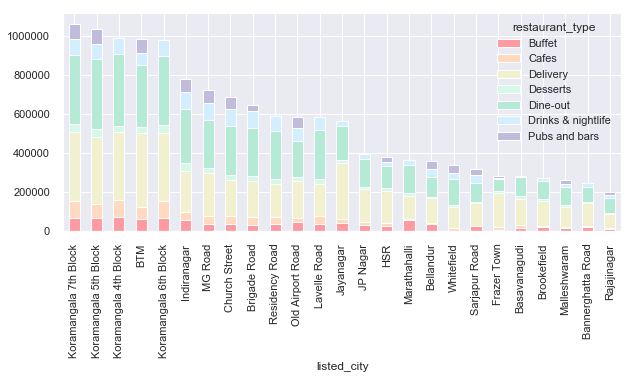

In [134]:
# #### Splitting cusine and restaurant category to visualisise
StackBarVotes('listed_city','restaurant_type','votes',data=DataFull)

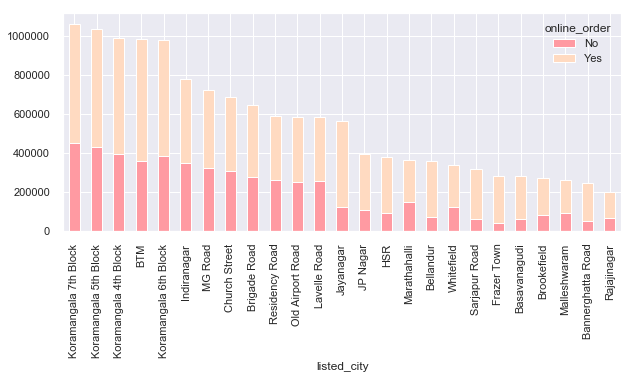

In [135]:
StackBarVotes('listed_city','online_order','votes',data=DataFull)

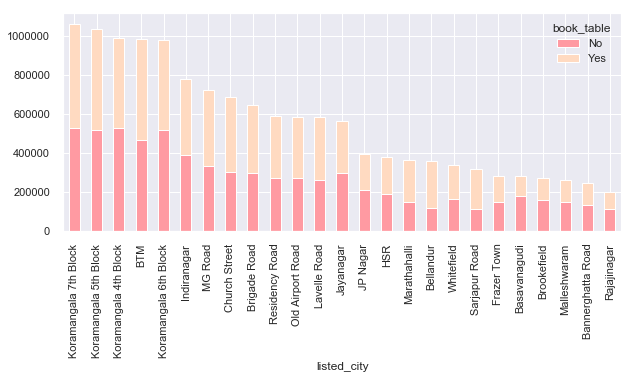

In [136]:
StackBarVotes('listed_city','book_table','votes',data=DataFull)

### Not finished 

In [141]:
'''
# Here I was trying to create sth that cuts groups with less than 5% numver of observation in each 
StackBarVotes2('Neighbourhood','restaurant_category','votes')




# 
# This below does not make any sense cause we missing biggest neigbourhoods because of divison

#StackBarVotes2('Neighbourhood','cuisines','votes',5,colors="tab20b")
#requires fixing wrong labels - sth to do with indexing


#proof
group=data.groupby(['Neighbourhood','cuisines']).agg({'votes': ['sum']})
g=group.reset_index()
gperc = group.groupby(level=0).apply(lambda x:100 * x / float(x.sum()))
gpercf= gperc[gperc > 5].reset_index().dropna()
#gpercf
'''

'\n# Here I was trying to create sth that cuts groups with less than 5% numver of observation in each \nStackBarVotes2(\'Neighbourhood\',\'restaurant_category\',\'votes\')\n\n\n\n\n# \n# This below does not make any sense cause we missing biggest neigbourhoods because of divison\n\n#StackBarVotes2(\'Neighbourhood\',\'cuisines\',\'votes\',5,colors="tab20b")\n#requires fixing wrong labels - sth to do with indexing\n\n\n#proof\ngroup=data.groupby([\'Neighbourhood\',\'cuisines\']).agg({\'votes\': [\'sum\']})\ng=group.reset_index()\ngperc = group.groupby(level=0).apply(lambda x:100 * x / float(x.sum()))\ngpercf= gperc[gperc > 5].reset_index().dropna()\n#gpercf\n'

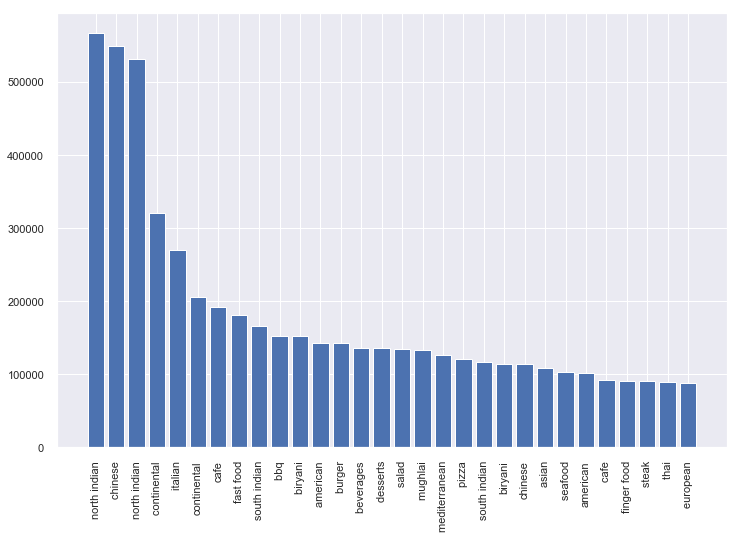

In [138]:
# #### Cusinine Dict
# 
# I have decided to manipulate with this feature to represent more accurately.

cuisine_list={}
for index, row in data.iterrows():
    #print(type(row['cuisines']), type(row['votes']))
    tokens = row['cuisines']
    for t in str(tokens).split(','):
        if t in cuisine_list.keys():
            cuisine_list[t] += row['votes']
        else:
            cuisine_list[t] = row['votes']



lists = sorted(cuisine_list.items(), key=lambda item: item[1], reverse=True)
x, y = zip(*lists) # unpack a list of pairs into two tuples
fig= plt.figure(figsize=(12,8))
plt.bar(x[:30],y[:30])
plt.xticks(rotation=90)
plt.show()

### Rate's analysis

##### One feature analysis

##### 10 listed localization with the higher avg rate

In [252]:
data_agg=DataFull.groupby('listed_city')['rate'].agg(np.mean).sort_values(ascending=False)[:10]
data_agg

listed_city
Church Street            3.787102
MG Road                  3.786375
Brigade Road             3.784923
Residency Road           3.768159
Lavelle Road             3.764294
Koramangala 6th Block    3.751702
Koramangala 4th Block    3.748515
Koramangala 5th Block    3.748466
Koramangala 7th Block    3.747599
Indiranagar              3.738246
Name: rate, dtype: float64

In [253]:
data_agg=DataFull.groupby('listed_city')['votes'].agg(np.sum).sort_values(ascending=False)[:10]
data_agg
# Church street has the highest avg. rate but has less votes than Koramangala's block that are also in top. 
#Diferences beetwen avg. rating per localization are not high


listed_city
Koramangala 7th Block    1065901.0
Koramangala 5th Block    1040312.0
Koramangala 4th Block     992065.0
BTM                       985690.0
Koramangala 6th Block     978900.0
Indiranagar               781831.0
MG Road                   722679.0
Church Street             687895.0
Brigade Road              648458.0
Residency Road            588107.0
Name: votes, dtype: float64

##### 10 restaurant types with the higher avg rate

In [254]:
DataFull.groupby('restaurant_type')['rate'].agg(np.mean).sort_values(ascending=False)[:10]

restaurant_type
Drinks & nightlife    4.003833
Pubs and bars         3.997023
Buffet                3.973483
Cafes                 3.852808
Desserts              3.758666
Dine-out              3.684769
Delivery              3.662885
Name: rate, dtype: float64

In [255]:
DataFull.groupby('restaurant_type')['votes'].agg(np.sum).sort_values(ascending=False)[:10]
# Pubs and bars has less votes but o avg they are higher. 
#The most represented category Deliveries has the lowest rating.

restaurant_type
Delivery              5291258.0
Dine-out              5155348.0
Drinks & nightlife    1262257.0
Buffet                 889438.0
Cafes                  826857.0
Pubs and bars          705533.0
Desserts               541294.0
Name: votes, dtype: float64

##### 15 restaurant categories with the higher avg rate

In [256]:
data.groupby('restaurant_category')['rate'].agg(np.mean).sort_values(ascending=False)[:15]

restaurant_category
Bar, Pub                       4.600000
Pub, Cafe                      4.550000
Microbrewery, Pub              4.487500
Cafe, Lounge                   4.400000
Microbrewery, Bar              4.400000
Fine Dining, Lounge            4.400000
Casual Dining, Irani Cafee     4.400000
Microbrewery                   4.370935
Fine Dining, Microbrewery      4.300000
Microbrewery, Casual Dining    4.273601
Casual Dining, Microbrewery    4.250000
Fine Dining, Bar               4.244444
Pub, Microbrewery              4.227914
Microbrewery, Lounge           4.200000
Casual Dining, Cafe            4.198140
Name: rate, dtype: float64

In [257]:
data.groupby('restaurant_category')['votes'].agg(np.sum).sort_values(ascending=False)[:15]

restaurant_category
Casual Dining          816742.0
Quick Bites            354417.0
Cafe                   149301.0
Casual Dining, Bar     135604.0
Dessert Parlor          65312.0
Casual Dining, Cafe     58187.0
Delivery                57785.0
Bar, Casual Dining      53836.0
Pub                     45348.0
Lounge                  42111.0
Microbrewery, Pub       40052.0
Microbrewery            38647.0
Cafe, Casual Dining     35170.0
Pub, Microbrewery       34161.0
Fine Dining             31201.0
Name: votes, dtype: float64

In [258]:
df_agg = data.groupby(['restaurant_type']).agg({'rate':'mean', 'votes':'sum'}).sort_values('votes',ascending=False)
df_agg

,rate,votes
restaurant_type,,
Delivery,3.602380,1265100.0
Dine-out,3.623582,476180.0
Buffet,3.948122,278088.0
Cafes,3.771880,195461.0
Desserts,3.665250,39580.0
Drinks & nightlife,3.647104,2544.0
Pubs and bars,3.777527,1414.0


In [259]:
df_agg = data.groupby(['restaurant_category']).agg({'rate':'mean', 'votes':'sum'}).sort_values('votes',ascending=False)
df_agg

,rate,votes
restaurant_category,,
Casual Dining,3.674329,816742.0
Quick Bites,3.553432,354417.0
Cafe,3.729075,149301.0
"Casual Dining, Bar",3.930918,135604.0
Dessert Parlor,3.773830,65312.0
"Casual Dining, Cafe",4.198140,58187.0
Delivery,3.585468,57785.0
"Bar, Casual Dining",4.027707,53836.0
Pub,3.930027,45348.0


##### Overlaps?

In [260]:
df_agg = data.groupby(['restaurant_type','restaurant_category']).agg({'rate':'mean', 'votes':'sum'}).sort_values('votes',ascending=False)
df_agg

rate     votes
restaurant_type    restaurant_category                            
Delivery           Casual Dining                3.646410  515000.0
                   Quick Bites                  3.552563  272391.0
Buffet             Casual Dining                3.904116  183391.0
Dine-out           Casual Dining                3.666235  117009.0
Cafes              Cafe                         3.725140  105878.0
Dine-out           Quick Bites                  3.550878   79020.0
Delivery           Casual Dining, Bar           4.028480   57525.0
                   Delivery                     3.580195   57317.0
Buffet             Casual Dining, Bar           4.039286   43326.0
Delivery           Dessert Parlor               3.776800   42889.0
                   Cafe                         3.804744   40979.0
Dine-out           Bar, Casual Dining           4.035252   37932.0
                   Casual Dining, Bar           3.800942   34498.0
Cafes              Casual Dining, Cafe          4.185600   30463.0
Delivery           Takeaway, Delivery           3.559073   28659.0
Cafes              Cafe, Casual Dining          4.050000   26226.0
Delivery           Casual Dining, Cafe          4.230000   25524.0
Dine-out           Microbrewery, Pub            4.520000   25133.0
                   Pub                          3.858972   23412.0
Desserts           Dessert Parlor               3.759803   21366.0
Delivery           Lounge                       4.077778   20819.0
                   Microbrewery                 4.650000   20654.0
Dine-out           Pub, Microbrewery            4.245122   20543.0
                   Lounge                       3.797917   19273.0
Delivery           Pub                          4.085714   18499.0
Dine-out           Microbrewery                 4.231403   17993.0
                   Fine Dining                  4.148569   16917.0
                   Bar                          3.726655   16042.0
Delivery           Microbrewery, Pub            4.433333   14919.0
Dine-out           Pub, Casual Dining           4.060000   14455.0
...                                                  ...       ...
Desserts           Confectionery                3.583741      19.0
Dine-out           Quick Bites, Kiosk           3.300000      14.0
Delivery           Dessert Parlor, Sweet Shop   3.300000      13.0
Desserts           Dessert Parlor, Food Court   3.700000      12.0
Buffet             Food Court                   2.800000      11.0
Delivery           Casual Dining, Quick Bites   3.500000      10.0
Dine-out           Quick Bites, Beverage Shop   3.520489      10.0
Pubs and bars      Pub                          3.200000       8.0
Cafes              Delivery                     3.550408       7.0
Delivery           Bhojanalya                   3.200000       4.0
Buffet             Cafe                         3.625612       0.0
Pubs and bars      Casual Dining, Bar           3.625612       0.0
Cafes              Bar, Cafe                    3.625612       0.0
Pubs and bars      Pub, Microbrewery            3.625612       0.0
                   Bar                          3.625612       0.0
Drinks & nightlife Quick Bites                  3.625612       0.0
Dine-out           Delivery                     3.625612       0.0
Cafes              Takeaway                     3.625612       0.0
                   Takeaway, Delivery           3.625612       0.0
Drinks & nightlife Bar, Casual Dining           3.625612       0.0
Delivery           Bakery, Kiosk                3.625612       0.0
Dine-out           Takeaway, Delivery           3.625612       0.0
                   Takeaway                     3.625612       0.0
                   Sweet Shop                   3.625612       0.0
Desserts           Bakery, Beverage Shop        3.625612       0.0
                   Bakery, Sweet Shop           3.625612       0.0
Dine-out           Mess, Quick Bites            3.625612       0.0
Desserts           Pop Up       

In [261]:
data_agg=data.groupby('restaurant_type')['rate'].agg(np.mean).sort_values(ascending=False)[:10]
data_agg

restaurant_type
Buffet                3.948122
Pubs and bars         3.777527
Cafes                 3.771880
Desserts              3.665250
Drinks & nightlife    3.647104
Dine-out              3.623582
Delivery              3.602380
Name: rate, dtype: float64

##### The highest scored restuarant

In [262]:
data.sort_values('rate',ascending=False)[['rest_name','Neighbourhood','rate']].head(20).drop_duplicates()

,rest_name,Neighbourhood,rate
5153,Belgian Waffle Factory,Brigade Road,4.9
45812,Sant Spa Cuisine,Old Airport Road,4.9
39559,Punjab Grill,Malleshwaram,4.9
7118,Punjab Grill,Brookefield,4.9
8260,ABs Absolute Barbecues,BTM,4.9
6746,Flechazo,Brookefield,4.9
8275,Asia Kitchen By Mainland China,BTM,4.9
3921,Byg Brewski Brewing Company,Bellandur,4.9
18496,Milano Ice Cream,Indiranagar,4.9
23937,Belgian Waffle Factory,Kalyan Nagar,4.8


In [263]:
grouped = data.groupby('Neighbourhood')['rate'].agg([min, max, np.mean]) 
grouped

,min,max,mean
Neighbourhood,,,
BTM,2.3,4.9,3.687317
Banashankari,2.5,4.7,3.655645
Bannerghatta Road,2.2,4.7,3.568441
Basavanagudi,2.6,4.8,3.682286
Bellandur,2.1,4.9,3.600335
Brigade Road,1.8,4.9,3.735865
Brookefield,2.1,4.9,3.572204
Church Street,2.7,4.4,3.677339
Electronic City,2.4,4.7,3.528911


In [268]:
# #### One level aggregations

df_by_niegbourhood = DataFull.groupby('listed_city').agg({'rate':'median','votes':'sum'}).reset_index()
df_by_location = data.groupby('location').agg({'rate':'median','votes':'sum'}).reset_index()
df_by_restcat = data.groupby('restaurant_category').agg({'rate':'median','votes':'sum'}).reset_index()
df_by_resttype = DataFull.groupby('restaurant_type').agg({'rate':'median','votes':'sum'}).reset_index()


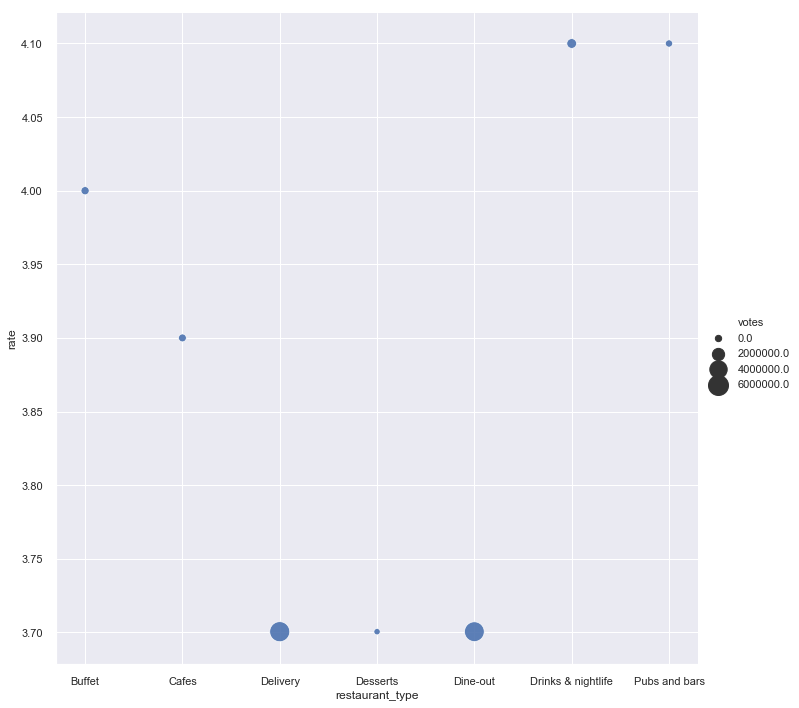

In [273]:
sns.relplot(x="restaurant_type", y="rate", size="votes",
            sizes=(40, 400), alpha=.9, palette="Paired",
            height=10, data=df_by_resttype)

In [277]:
DataFull.columns.values

array(['rest_name', 'online_order', 'book_table', 'rate', 'votes',
       'location', 'restaurant_category', 'dish_liked', 'cuisines',
       'meal_cost', 'reviews_list', 'menu_item', 'restaurant_type',
       'listed_city'], dtype=object)

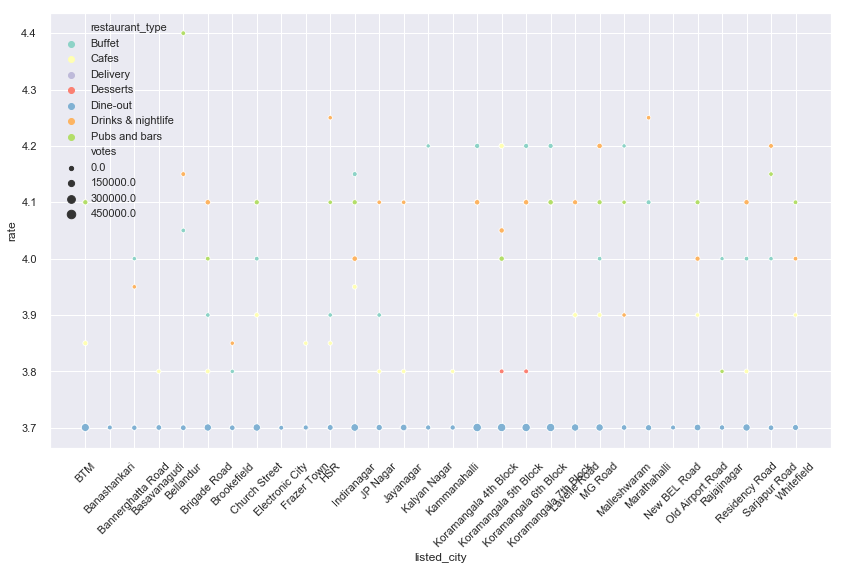

In [279]:
# ### 2 level aggregatios

df_by_locneigh = DataFull.groupby(['listed_city','restaurant_type']).agg({'rate':'median','votes':'sum'}).reset_index()


g = sns.set(rc={'figure.figsize':((14,8))})
g = sns.scatterplot(x="listed_city", y="rate", size="votes", hue='restaurant_type',
                palette='Set3', data=df_by_locneigh[df_by_locneigh['votes']>10000])
plt.xticks(rotation=45)
plt.show()


#data.sort_values('rate',ascending=False)[['name','Cusine','rate']].head(20).drop_duplicates()

#### Rate distribution

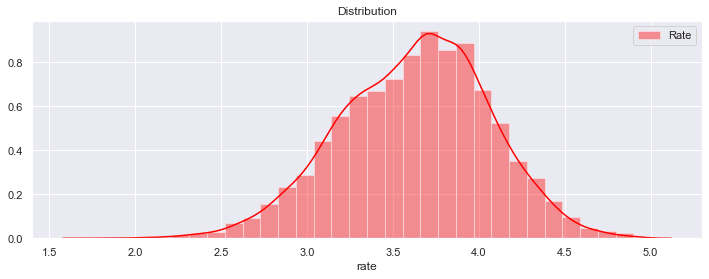

In [248]:
plt.figure(figsize=(12,4))
plt.title("Distribution")
sns.distplot(data['rate'],color="red", kde=True,bins=30, label='Rate')
plt.legend()
plt.show()

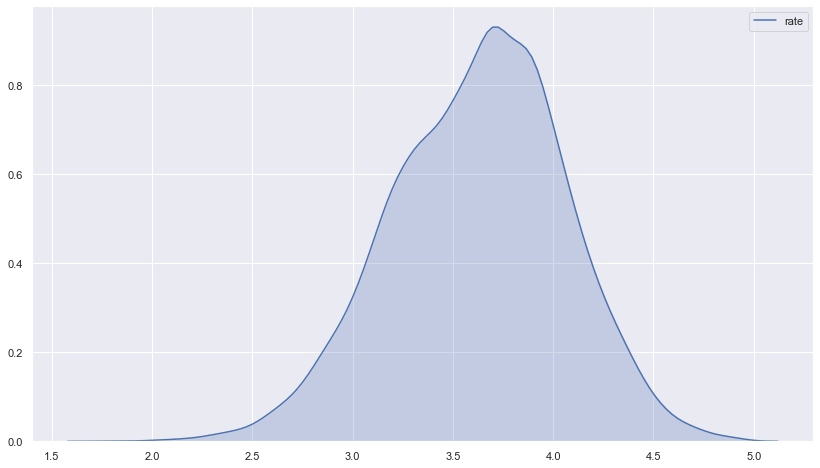

In [249]:
sns.kdeplot(data['rate'], shade=True)

#### Cost of dish

In [250]:
data['meal_cost'].head() # needs preprocessing

0    800.0
1    800.0
2    800.0
3    300.0
4    600.0
Name: meal_cost, dtype: float64

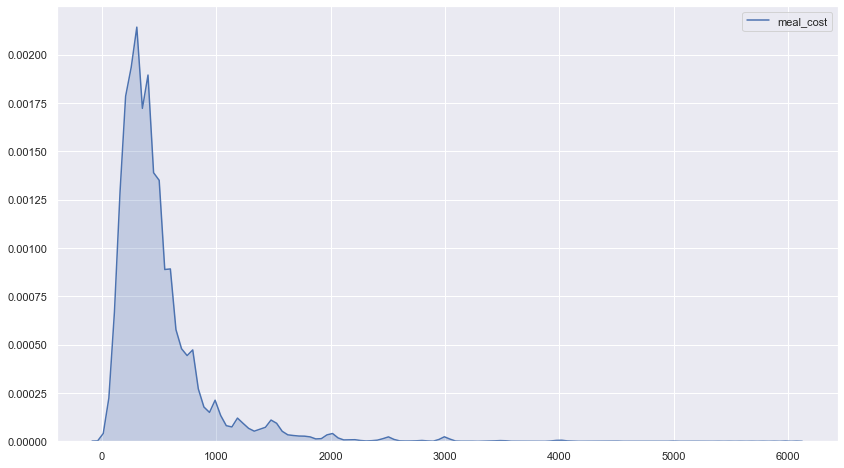

In [251]:
sns.kdeplot(data['meal_cost'], shade=True)

In [252]:
data.meal_cost.describe()

count    12440.00000
mean       487.20000
std        390.85198
min         40.00000
25%        250.00000
50%        400.00000
75%        600.00000
max       6000.00000
Name: meal_cost, dtype: float64

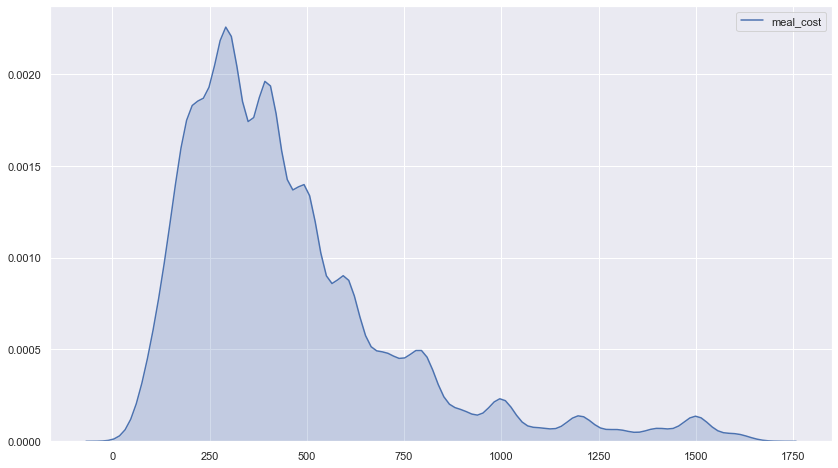

In [253]:
#### Removing abnormalities

# Assuming that this high valueof order is an error

AbnormValue=data.meal_cost.mean()+data.meal_cost.std()*3
final_list = [x for x in data.meal_cost if (x >AbnormValue)]
final_set = set(final_list) 
unique_list = (list(final_set))


data.loc[data.meal_cost.isin(unique_list)] = np.nan


sns.kdeplot(data['meal_cost'], shade=True)


### Geovisualization

In [31]:
locations=pd.DataFrame({"loc":data['location'].unique()})
locations['loc']=locations['loc'].apply(lambda x: "Bangalore " + str(x))
geo_xy=[]
geolocator=Nominatim(user_agent="app")
for location in locations['loc']:
    location = geolocator.geocode(location)
    if location is None:
        geo_xy.append(np.nan)
    else:    
        geo=(location.latitude,location.longitude)
        geo_xy.append(geo)


locations['geo_loc']=geo_xy





# https://github.com/geopy/geopy/issues/171
# https://gis.stackexchange.com/questions/198530/plotting-us-cities-on-a-map-with-matplotlib-and-basemap/198570



In [32]:
locations[locations['geo_loc'].isna()]

,loc,geo_loc
6,Bangalore Vijay Nagar,NaN
17,Bangalore CV Raman Nagar,NaN
64,Bangalore Brookefield,NaN
65,"Bangalore ITPL Main Road, Whitefield",NaN
80,Bangalore Rammurthy Nagar,NaN
86,Bangalore Sadashiv Nagar,NaN


In [33]:
locations = locations.dropna().reset_index()

In [34]:
data['location2'] = data['location'].apply(lambda x: "Bangalore " + str(x))

In [35]:
data_agg=data.groupby('location2')['rate'].agg(np.mean)

In [36]:
datageo=pd.merge(data_agg, locations, left_on='location2', right_on='loc', how='inner')

In [37]:
datageo

,rate,index,loc,geo_loc
0,3.576756,13,Bangalore BTM,"(12.91127585, 77.6045654343118)"
1,3.625904,0,Bangalore Banashankari,"(12.9152208, 77.573598)"
2,3.522074,73,Bangalore Banaswadi,"(13.0141618, 77.6518539)"
3,3.515139,12,Bangalore Bannerghatta Road,"(12.9166588, 77.5998415)"
4,3.667160,1,Bangalore Basavanagudi,"(12.9417261, 77.5755021)"
5,3.606412,87,Bangalore Basaveshwara Nagar,"(12.9932236, 77.5391579)"
6,3.529581,30,Bangalore Bellandur,"(12.9791198, 77.5912997)"
7,3.405781,15,Bangalore Bommanahalli,"(13.3457317, 77.4333346)"
8,3.667092,39,Bangalore Brigade Road,"(12.9736132, 77.6074716)"
9,3.700000,62,Bangalore Central Bangalore,"(12.97339325, 77.6112342691467)"


In [395]:
asdf = datageo["geo_loc"].tolist()
x, y = zip(*asdf)
#map(x,y,marker='o',color='Red',markersize=row["rate"])
#plt.show()


In [38]:
os.chdir('/Users/gosc/Desktop/Kaggle') 

In [39]:
import geopandas as gpd
import descartes
from shapely.geometry import Point, Polygon
#https://towardsdatascience.com/geopandas-101-plot-any-data-with-a-latitude-and-longitude-on-a-map-98e01944b972
g=gpd.read_file("/Users/gosc/Desktop/Kaggle/Ih_IntroductiontoSpatialAnalysiswithGeopandas/Shp/Guayaqui_Poligonos.shp")

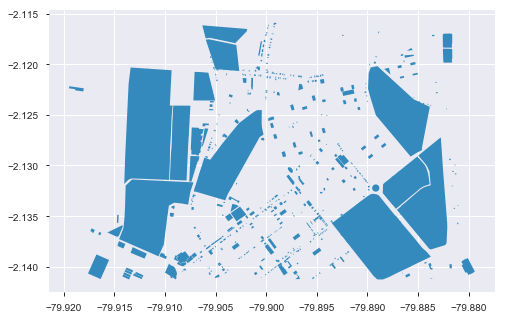

In [40]:
g.plot()

In [41]:
geo = datageo["geo_loc"].tolist()
x, y = zip(*geo)
crs = {'init': 'espg:4326'}

In [48]:
geometry=[Point(xy) for xy in zip(geo)]

In [50]:
geo_df=gpd.GeoDataFrame(datageo, crs=crs, geometry=geometry)

No handles with labels found to put in legend.


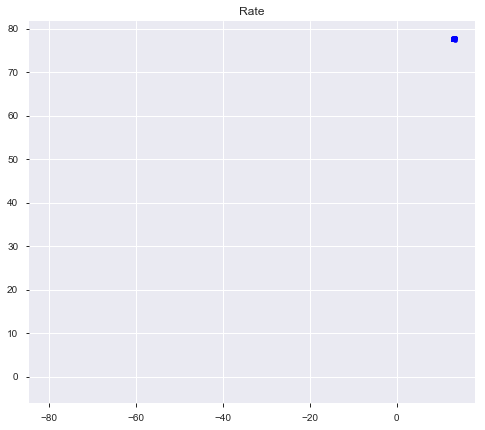

In [55]:

fig, ax = plt.subplots(figsize = (8,8))
g.plot(ax=ax, alpha=0.4, color='grey')
geo_df.plot(ax=ax, markersize= 20, color="blue")
plt.title('Rate')
plt.legend()

### TEXT PROCESSING

##### DISH LIKED

In [229]:
# Spliting text columns

words_list=[]
for dish in data['dish_liked']:
    dish = str(dish)
    tokens = dish.split()
    for t in tokens:
        t = t.replace(',', '')
        if t != 'nan':
            words_list.append(t)


DishedDF=pd.DataFrame(words_list)
DishedDF[0].value_counts().head(5)

Chicken      2812
Biryani      1602
Pizza         756
Masala        649
Chocolate     617
Name: 0, dtype: int64

##### Menu Item

In [233]:
d=data['menu_item']
menu=[]
for dish in d:
    dish = str(dish)
    dish = dish.replace('\\', '')
    dish = dish.replace('[', '')
    dish = dish.replace(']', '')
    tokens = dish.split("', '")
    for t in tokens:
        t = t.replace(',', '')
        if len(t)>0:
            menu.append(t)


menudf=pd.DataFrame(menu)
menudf[0].value_counts().head(5)

Chicken Fried Rice      752
Veg Fried Rice          739
Paneer Butter Masala    648
Jeera Rice              635
Egg Fried Rice          613
Name: 0, dtype: int64

#### Defining word count/ cloud function

In [230]:
def WordCount(WordsList, limit=30):
    plt.figure(figsize=(10,4))
    sns.countplot(pd.DataFrame(WordsList)[0], 
    palette='Set3',order = pd.DataFrame(WordsList)[0].value_counts().head(limit).index)
    plt.xticks(rotation=90)

def wordCloud(data, backgroundcolor="white", wordmax=80, sizefont=20, color='steelblue'):
    wc = WordCloud(background_color=backgroundcolor, 
                   max_words=wordmax, max_font_size=sizefont, scale=10, contour_color=color)
    wc.generate(' '.join(data))
    plt.figure()
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.show()

#### Dish liked

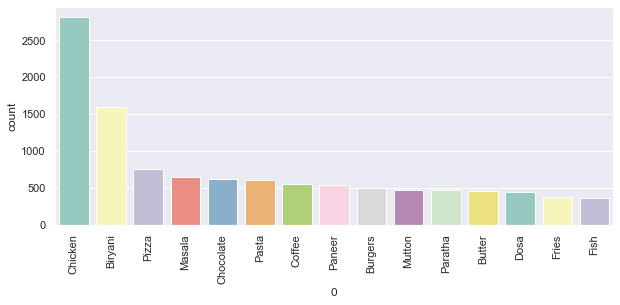

In [231]:
WordCount(words_list, 15)

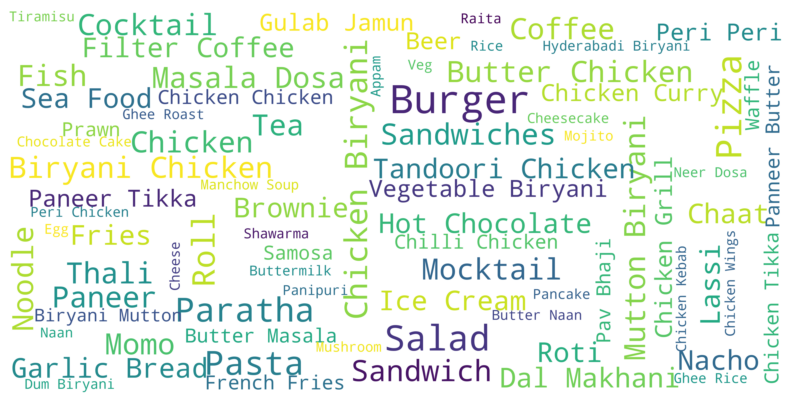

In [232]:
wordCloud(words_list)

#### Menu items

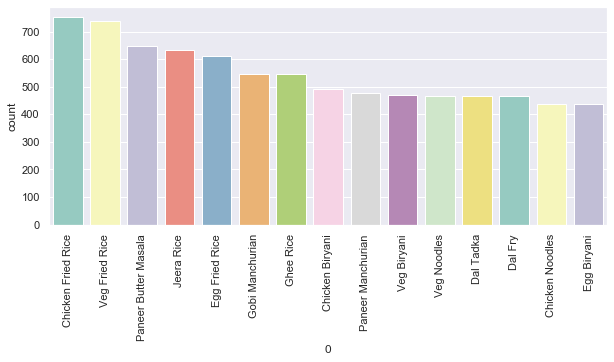

In [236]:
WordCount(menudf, 15)

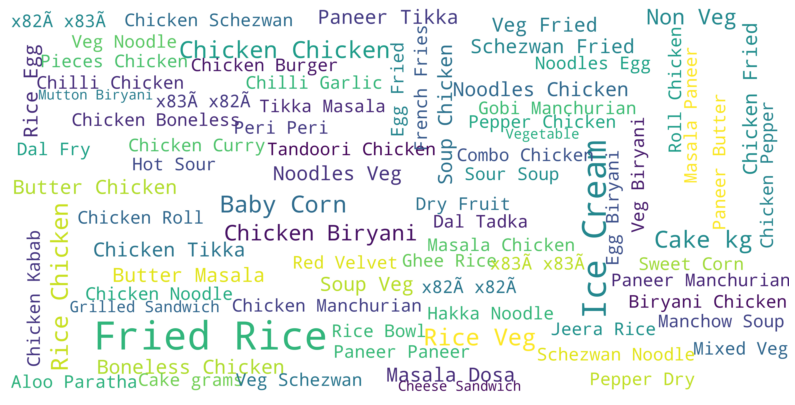

In [238]:
wordCloud(menu)

#### Reviews

In [239]:
data.reviews_list.head(5)

0    [('Rated 4.0', 'RATED\n  A beautiful place to ...
1    [('Rated 4.0', 'RATED\n  Had been here for din...
2    [('Rated 3.0', "RATED\n  Ambience is not that ...
3    [('Rated 4.0', "RATED\n  Great food and proper...
4    [('Rated 4.0', 'RATED\n  Very good restaurant ...
Name: reviews_list, dtype: object

In [241]:
# Splitting columns

reviews=data.reviews_list.copy()
sentences_tokens = []

In [245]:
for i in range(len(reviews[:10])):#first 10
    review = reviews[i]
    review = re.sub(r'\\n|\\x|\.', ' ', review)
    tokens = re.sub("[^a-z ]+", "", review.lower())
    tokens = tokens.split()
    tokens = [w for w in tokens if (w not in set(stopwords.words('english')) and (w!='rated'))]
    sentences_tokens.extend(tokens)
        

len(sentences_tokens)

18378

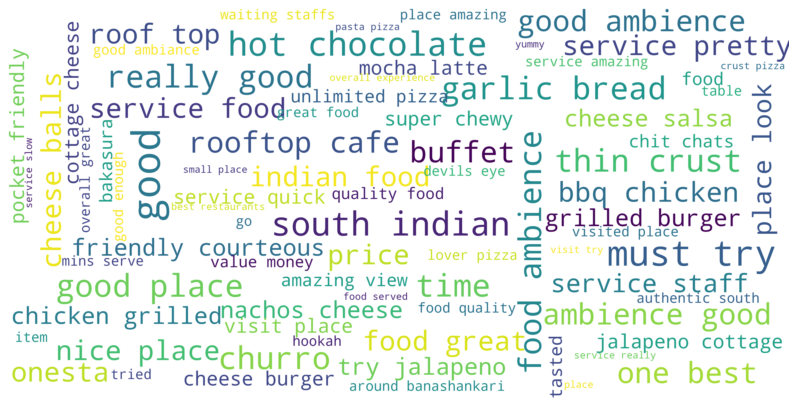

In [246]:
wordCloud(sentences_tokens)

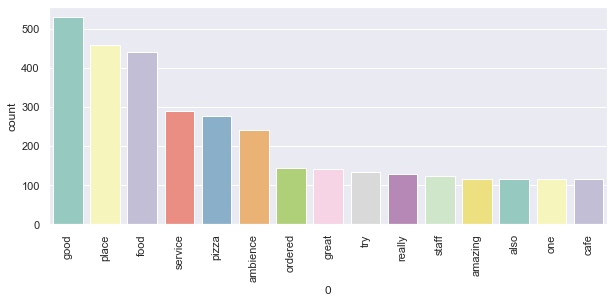

In [247]:
WordCount(sentences_tokens, 15)

### Next steps

#### Bag of word and sentiment analysis